# V-Cycles

We now have what we need to apply this two-grid solver recursively.  Instead of solving the coarse grid directly via smoothing, we instead treat it like a new Poisson problem to solve and create an even coarser grid to do the correction, and so on...

Eventually, we will have a tower of grids spanning from our original fine grid resolution down to something suitably coarse that we can relax the solution there with only a few iterations:

![multgrid tower](mgtower.png)


To make things simpler, we'll work with grids that are a power of 2 in size.  Then we will coarsen all the way down until we have a grid with only 2 zones (because of how we implement our boundary conditions, we can't go all the way down to a single zone).

On that 2 zone coarsest grid, just a few smoothing iterations will solve the problem.  We call this the *bottom solver*.

Here's a multigrid class that implements this recursive structure.  It is currently implemented only for homogeneous boundary conditions.

The main data structure is a list of grids, `Multigrid.grids`, which holds the hierarchy of grids at the different resolutions.

Our two-grid correction code that we previously implemented is now called `vcycle()`, and it will apply the two-grid correction on all grids except the very coarsest, on which it instead just smooths.

Finally, there is one new function here, `solve()`.  This calls `vcycle()` repeatedly until the error is below our desired tolerance.

The overall flow looks like:

![vcycle](vcycle.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import multigrid

In [3]:
%cat multigrid.py

import numpy as np

import grid


class Multigrid:
    """
    The main multigrid class for cell-centered data.

    We require that nx be a power of 2 for simplicity
    """

    def __init__(self, nx, xmin=0.0, xmax=1.0,
                 bc_left_type="dirichlet", bc_right_type="dirichlet",
                 nsmooth=10, nsmooth_bottom=50,
                 verbose=0,
                 true_function=None):

        self.nx = nx
        self.ng = 1

        self.xmin = xmin
        self.xmax = xmax

        self.nsmooth = nsmooth
        self.nsmooth_bottom = nsmooth_bottom

        self.max_cycles = 100

        self.verbose = verbose

        self.bc_left_type = bc_left_type
        self.bc_right_type = bc_right_type

        # a function that gives the analytic solution (if available)
        # for diagnostics only
        self.true_function = true_function

        # assume that self.nx = 2^(nlevels-1)
        # this defines nlevels such that we end exactly on a 2 zone grid
        sel

Let's try this out

In [4]:
def true(x):
    # the analytic solution
    return -np.sin(x) + x*np.sin(1.0)

def f(x):
    # the righthand side
    return np.sin(x)

In [5]:
nx = 128

# create the multigrid object
a = multigrid.Multigrid(nx,
                        bc_left_type="dirichlet", bc_right_type="dirichlet",
                        verbose=1, true_function=true)

# initialize the RHS using the function f
a.init_rhs(f(a.x))

# solve to a relative tolerance of 1.e-11
elist, rlist = a.solve(rtol=1.e-11)

source norm =  0.5221813198632965
<<< beginning V-cycle (cycle 1) >>>

  level = 6, nx =  128, residual change:    0.522181 ->    0.700617
  level = 5, nx =   64, residual change:    0.495162 ->    0.649824
  level = 4, nx =   32, residual change:    0.459083 ->    0.549621
  level = 3, nx =   16, residual change:    0.387872 ->    0.351795
  level = 2, nx =    8, residual change:    0.247396 ->   0.0731208
  level = 1, nx =    4, residual change:   0.0502257 -> 4.11445e-05
  bottom solve
  level = 1, nx =    4, residual change: 3.04921e-05 -> 3.62431e-09
  level = 2, nx =    8, residual change:   0.0618107 -> 0.000937419
  level = 3, nx =   16, residual change:     0.37581 ->  0.00791276
  level = 4, nx =   32, residual change:    0.769146 ->   0.0206557
  level = 5, nx =   64, residual change:     1.23875 ->   0.0291926
  level = 6, nx =  128, residual change:      1.8559 ->   0.0338419
cycle 1: residual err / source norm =   0.0648087

<<< beginning V-cycle (cycle 2) >>>

  level = 

Notice that it did 11 V-cycles.  

We also see that each V-cycle reduces the residual error by about an order of magnitude&mdash;this is a good rule-of-thumb for multigrid.

We can also compute the error with respect to the analytic solution (since we know that for this case):

In [9]:
# get the solution 
v = a.get_solution()

# compute the error from the analytic solution
e = v - true(a.x)

print(f"L2 error from true solution = {a.soln_grid.norm(e)}")

L2 error from true solution = 3.8905913165725256e-06


Now let's plot the solution and how the error changes as a function of cycle

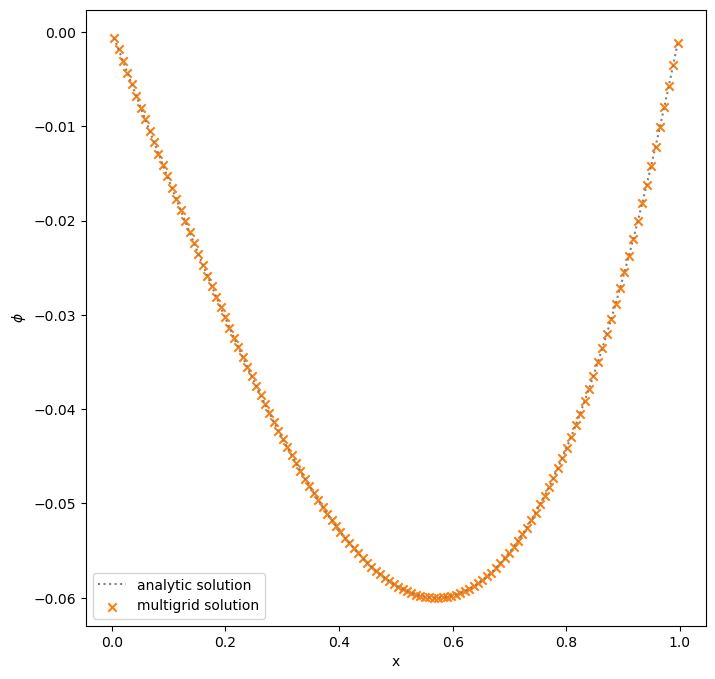

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(a.x[a.ilo:a.ihi+1], true(a.x[a.ilo:a.ihi+1]),
        color="0.5", ls=":", label="analytic solution")
ax.scatter(a.x[a.ilo:a.ihi+1], v[a.ilo:a.ihi+1],
           color="C1", label="multigrid solution", marker="x")
ax.set_xlabel("x")
ax.set_ylabel(r"$\phi$")
ax.legend()

fig.set_size_inches(8.0, 8.0)

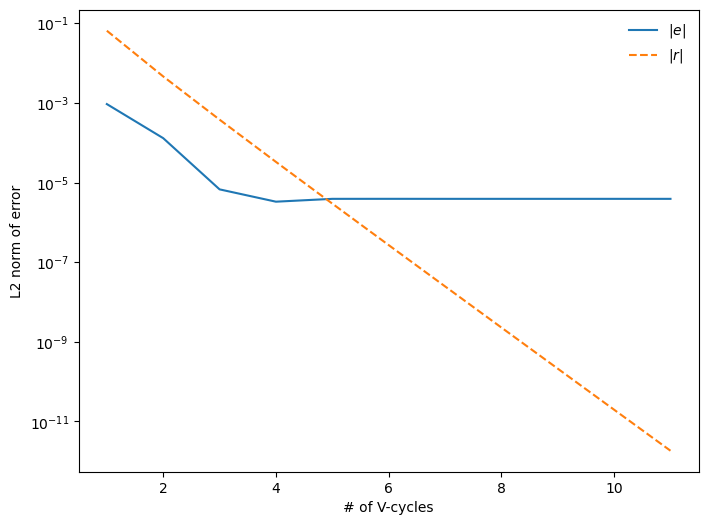

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ncycle = np.arange(len(elist)) + 1

ax.plot(ncycle, elist, label=r"$\| e\|$")
ax.plot(ncycle, rlist, "--", label=r"$\| r\|$")

ax.set_xlabel("# of V-cycles")
ax.set_ylabel("L2 norm of error")

ax.set_yscale('log')

fig.set_size_inches(8.0,6.0)

ax.legend(frameon=False)

We see the same behavior as we did with smoothing: the true error, $\| e \|$ stalls because of the truncation error of our discretization, but the residual error, $\| r \|$ keeps
decreasing (at least until it reaches roundoff error).